In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import dates
from netCDF4 import num2date,date2num,Dataset
import scipy.interpolate as interpolate
import pyproj
import os, subprocess, time, copy
from joblib import Parallel, delayed
import datetime
import cPickle as pickle
from mpl_toolkits.basemap import Basemap
import mahotas, pymorph, pylab
import scipy.ndimage as ndi
import matplotlib.gridspec as gridspec
from math import radians, sin, cos, sqrt, asin
from matplotlib.colors import LogNorm
from netCDF4 import num2date,date2num,Dataset
import matplotlib._pylab_helpers
#from joblib import Parallel, delayed
import scipy.stats as stats
from scipy.stats import pearsonr
from scipy.stats.mstats import scoreatpercentile
import scipy
#import math
import cPickle as pickle
import pandas as pd
#import pickle
import pprint
import csv
import pysal
from marcus_py_tools import walklevel, make_edge_vec, xy_from_latlon, latlon_from_xy, haversine
%matplotlib inline

In [2]:
filenm = '/home/mvanlier/mvanlier/mrdss/out_mrdss/LES_to_DS_marcus_018000_sgpk.nc'
nc = Dataset(filenm,'r')
xd = nc.variables['x'][:]
yd = nc.variables['y'][:]
zd = nc.variables['z'][:]
zrd = nc.variables['zr'][:]
dbz_mie = nc.variables['dBZ_mie'][:,:,:]    #..nz,ny,nx
spc_wid = nc.variables['Width'][:,:,:]
mdv     = nc.variables['Velo'][:,:,:]
dbz_sim = nc.variables['dBZ_sim_rad'][:,:,:]
mdv_sim = nc.variables['Velo_rad'][:,:,:]
nc.close()
dbz_mie = np.ma.masked_where(np.isinf(dbz_mie),dbz_mie)

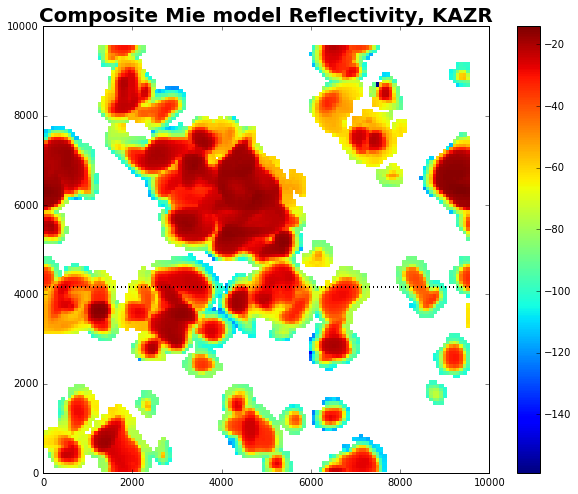

In [31]:
fig=plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.pcolormesh(xd,yd,dbz_mie[:,:,:].max(axis=0))
plt.plot([xd[0],xd[-1]],[yd[55],yd[55]],'k:',lw=2)
#plt.pcolormesh(xd,yd,dbz_mie[60,:,:])
plt.title('Composite Mie model Reflectivity, KAZR',fontsize=20,fontweight='bold')
plt.colorbar()

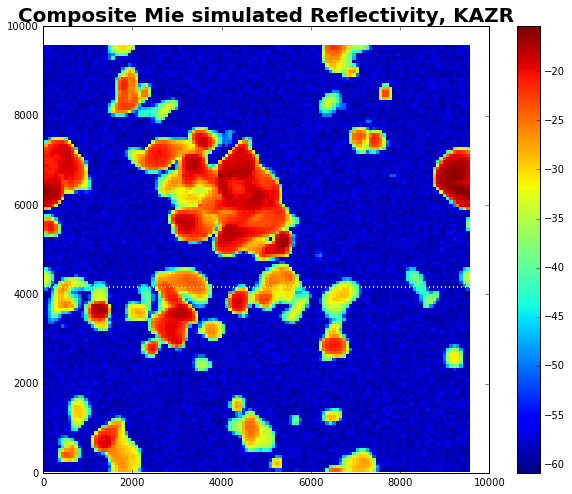

In [32]:
fig=plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.pcolormesh(xd,yd,dbz_sim[:,:,:].max(axis=0))
plt.plot([xd[0],xd[-1]],[yd[55],yd[55]],'w:',lw=2)
#plt.pcolormesh(xd,yd,dbz_sim[60,:,:])
plt.title('Composite Mie simulated Reflectivity, KAZR',fontsize=20,fontweight='bold')
plt.colorbar()

(37.5, 9562.5)

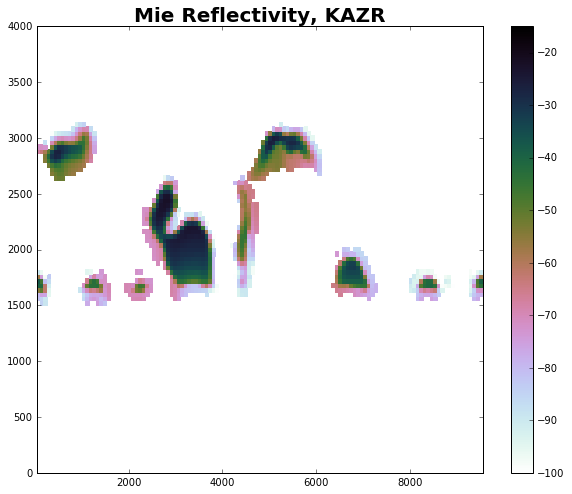

In [19]:
fig=plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
#plt.pcolormesh(xd,yd,dbz_mie[:,:,:].max(axis=0))
plt.pcolormesh(xd,zd,dbz_mie[:,55,:],vmin=-100,vmax=-15.,cmap=cm.cubehelix_r)
plt.colorbar()
plt.title('Mie Reflectivity, KAZR',fontsize=20,fontweight='bold')
ax.set_ylim(0.,4000.)
ax.set_xlim(xd.min(),xd.max())

(37.5, 9562.5)

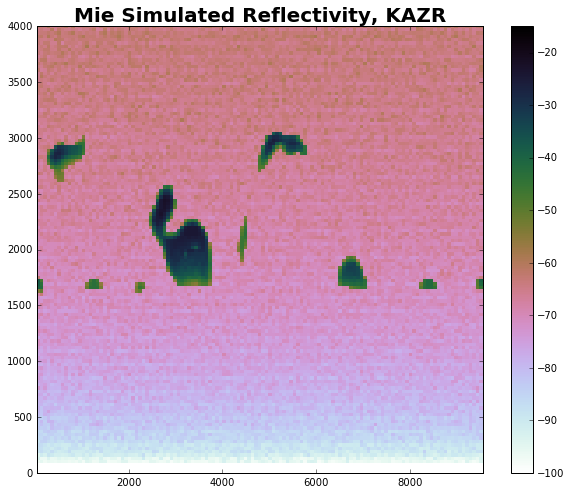

In [20]:
fig=plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
#plt.pcolormesh(xd,yd,dbz_mie[:,:,:].max(axis=0))
plt.pcolormesh(xd,zrd,dbz_sim[:,55,:],vmin=-100,vmax=-15.,cmap=cm.cubehelix_r)
plt.colorbar()
plt.title('Mie Simulated Reflectivity, KAZR',fontsize=20,fontweight='bold')
ax.set_ylim(0.,4000.)
ax.set_xlim(xd.min(),xd.max())

(37.5, 9562.5)

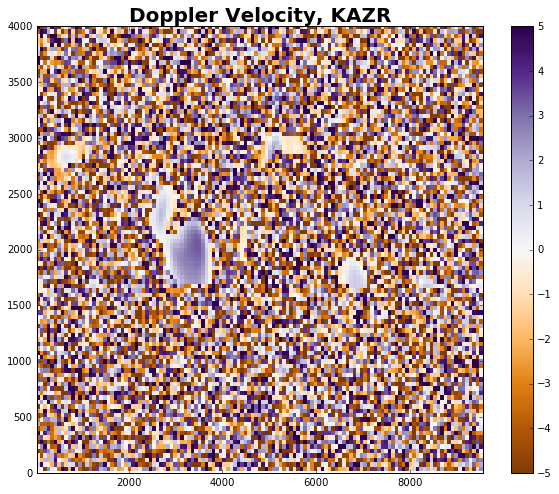

In [21]:
fig=plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
#plt.pcolormesh(xd,yd,dbz_mie[:,:,:].max(axis=0))
mdv_proc = np.ma.masked_where(dbz_mie<-60.,mdv)
#plt.pcolormesh(xd,zd,mdv_proc[:,55,:],cmap=cm.PuOr,vmin=-5,vmax=5)
plt.pcolormesh(xd,zd,mdv[:,55,:],cmap=cm.PuOr,vmin=-5,vmax=5)
plt.colorbar()
plt.title('Doppler Velocity, KAZR',fontsize=20,fontweight='bold')
ax.set_ylim(0.,4000.)
ax.set_xlim(xd.min(),xd.max())

(37.5, 9562.5)

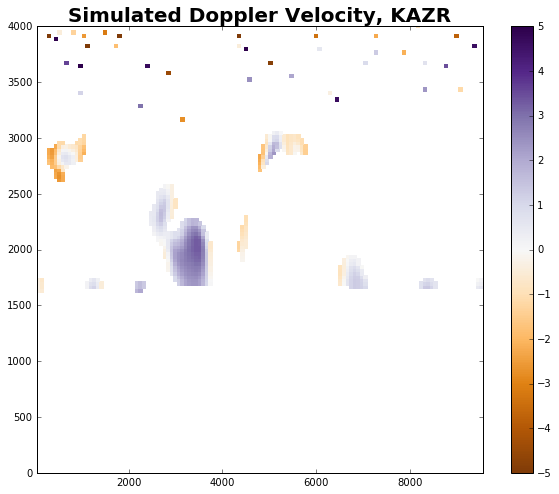

In [24]:
fig=plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
#plt.pcolormesh(xd,yd,dbz_mie[:,:,:].max(axis=0))
mdv_sim_proc = np.ma.masked_where(dbz_sim<-60.,mdv_sim)
plt.pcolormesh(xd,zrd,mdv_sim_proc[:,55,:],cmap=cm.PuOr,vmin=-5,vmax=5)
#plt.pcolormesh(xd,zrd,mdv_sim[:,55,:],cmap=cm.PuOr,vmin=-5,vmax=5)
plt.colorbar()
plt.title('Simulated Doppler Velocity, KAZR',fontsize=20,fontweight='bold')
ax.set_ylim(0.,4000.)
ax.set_xlim(xd.min(),xd.max())

(37.5, 9562.5)

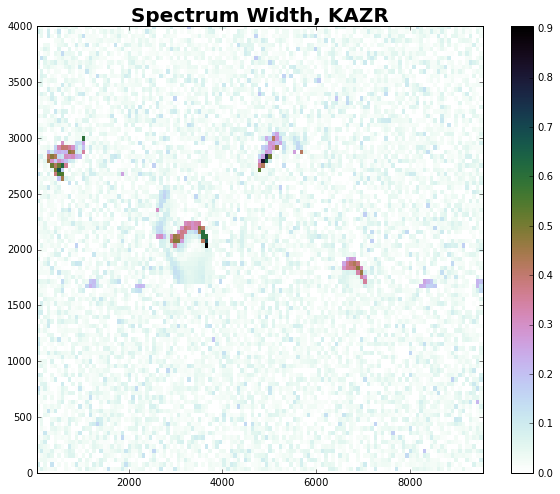

In [29]:
fig=plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
#plt.pcolormesh(xd,yd,dbz_mie[:,:,:].max(axis=0))
mdv_sim_proc = np.ma.masked_where(dbz_sim<-60.,mdv_sim)
plt.pcolormesh(xd,zd,spc_wid[:,55,:],cmap=cm.cubehelix_r)
#plt.pcolormesh(xd,zrd,mdv_sim[:,55,:],cmap=cm.PuOr,vmin=-5,vmax=5)
plt.colorbar()
plt.title('Spectrum Width, KAZR',fontsize=20,fontweight='bold')
ax.set_ylim(0.,4000.)
ax.set_xlim(xd.min(),xd.max())